In [1]:
#Imports 
import os
import sys 
os.chdir('..')
sys.path.insert(0, os.getcwd())
from AE_pipeline_pytorch import SemiSupAE, GaitBatchIterable, device
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from pathlib import Path
import json


import zarr
import numpy as np
import pandas as pd
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import joblib
from matplotlib.colors import ListedColormap


KeyboardInterrupt: 

In [2]:
#Load the model from the checkpoint
ckpt_path = Path("runs/semisup_3groups_20251119_124802/semisupae_last.pt")
ckpt = torch.load(ckpt_path, map_location=device)

model = SemiSupAE(
        steps=100,
        in_dim=321,
        latent=128,
        n_group=3,
        n_nuisance=None,
    ).to(device)

model.load_state_dict(ckpt["model"])   
model.eval()


SemiSupAE(
  (encoder): BiLSTMEncoder(
    (bilstm): LSTM(321, 128, batch_first=True, bidirectional=True)
    (to_latent): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
  )
  (decoder): LSTMDecoder(
    (init): Linear(in_features=128, out_features=128, bias=True)
    (lstm): LSTM(128, 128, batch_first=True)
    (out): Linear(in_features=128, out_features=321, bias=True)
  )
  (group_head): HeadMLP(
    (net): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=3, bias=True)
    )
  )
  (proj_head): ProjectionHead(
    (net): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
    )
  )
)

In [3]:
# test Dataloader with meta info
test_path = "test_cycles.zarr"
accum_steps = 1
micro_batch = 4096
num_workers = 8
prefetch = 6

test_loader = DataLoader(
    GaitBatchIterable(test_path, batch_size=micro_batch, return_meta=True),
    batch_size=None,
    num_workers=num_workers,
    pin_memory=True,
    persistent_workers=False,
    prefetch_factor=prefetch,
)

# Get one batch to inspect what the loader returns
batch = next(iter(test_loader))

if isinstance(batch, (list, tuple)) and len(batch) > 1:
    x_example, meta_example = batch
else:
    x_example, meta_example = batch, None

print("x_example shape:", x_example.shape)
print("meta_example type:", type(meta_example))

if isinstance(meta_example, dict):
    print("meta keys:", meta_example.keys())
elif isinstance(meta_example, torch.Tensor):
    print("meta_example shape:", meta_example.shape)

# Check model output
x_example = x_example.to(device)
with torch.no_grad():
    out_example = model(x_example, return_all=True)

x_example shape: torch.Size([4096, 100, 321])
meta_example type: <class 'torch.Tensor'>
meta_example shape: torch.Size([4096, 100, 5])


In [4]:
#Function to extract latent
def get_latent_from_semisup(out, use_proj=False):
    """
    Extract latent representation from SemiSupAE output dict.

    use_proj = False -> use encoder latent 'z'
    use_proj = True  -> use projection head 'proj'
    """
    if not isinstance(out, dict):
        raise TypeError("Expected dict output from model(x, return_all=True).")
    
    if use_proj:
        if "proj" not in out:
            raise KeyError("'proj' not found in model output keys: " + str(out.keys()))
        return out["proj"]
    else:
        if "z" not in out:
            raise KeyError("'z' not found in model output keys: " + str(out.keys()))
        return out["z"]

In [5]:
# latents, groups, subject_ids
latents_list  = []
features_list = [] 
groups_list   = []
subjects_list = []

print("Extracting latents and computing statistical features per batch...")

model.eval()
with torch.no_grad():
    for x_batch, meta in test_loader:
        x_batch = x_batch.to(device)
        
        # ----- 1) Latents (GPU) -----
        out = model(x_batch, return_all=True)
        z = get_latent_from_semisup(out, use_proj=False)
        latents_list.append(z.cpu().numpy()) 

        # ----- 2) Compute features on the fly (CPU) -----
        # Move the batch temporarily to CPU
        x_cpu = x_batch.cpu().numpy()  # (Batch_Size, 100, 321)
        
        # Compute statistics NOW so we don’t store x_cpu in memory
        # This compresses (100, 321) -> (3, 321) -> 963 features
        f_mean  = np.mean(x_cpu, axis=1)
        f_max   = np.max(x_cpu, axis=1)
        f_range = np.ptp(x_cpu, axis=1)  # Peak-to-peak (Max - Min)
        
        # Concatenate the 3 statistics: (Batch_Size, 963)
        batch_features = np.hstack([f_mean, f_max, f_range])
        
        # Save only the compressed summary
        features_list.append(batch_features)
        
        # (Here Python automatically frees x_cpu memory when moving to the next loop)

        # ----- 3) Metadata -----
        subj_codes = meta[:, 0, 0].long().cpu().numpy()
        subjects_list.append(subj_codes)

        group_codes = meta[:, 0, 1].long().cpu().numpy()
        groups_list.append(group_codes)

# Concatenate lists (they now fit in memory)
latents     = np.concatenate(latents_list,   axis=0)
X_features  = np.concatenate(features_list,  axis=0)  # This will weigh ~1GB
subject_ids = np.concatenate(subjects_list,  axis=0)
true_groups = np.concatenate(groups_list,    axis=0)

# Load GMM labels
try:
    gmm_labels = np.load('gmm_labels.npy')
except FileNotFoundError:
    print("gmm_labels.npy not found, make sure you ran the clustering step first.")



try: 
    HDBSCAN_labels = np.load('HDBSCAN_labels.npy')
except FileNotFoundError:
    print("HDBSCAN_labels.npy not found, make sure you ran the clustering step first.")

print("Latents shape:",   latents.shape)     # (N, 128)
print("Features shape:",  X_features.shape)  # (N, 963) <- Ready for XGBoost/SHAP
print("Groups shape:",    true_groups.shape)    


Extracting latents and computing statistical features per batch...
Latents shape: (61440, 128)
Features shape: (61440, 963)
Groups shape: (61440,)


In [6]:
# Create DataFrame for XAI – Feature engineering: Mean and Std for each variable across the 100 time steps
# Load original feature names (321)
# If the file is not available, fall back to generic names
try:
    with open('DataBesa_Variables_names.txt', 'r') as f:
        col_names_original = [line.strip() for line in f.readlines()]
except:
    col_names_original = [f"Var_{i}" for i in range(321)]

# Create extended names (963)
feature_names_stats = []
for suffix in ['_mean', '_max', '_range']:
    for name in col_names_original:
        feature_names_stats.append(f"{name}{suffix}")

# Create DataFrame ready for SHAP
X_df = pd.DataFrame(X_features, columns=feature_names_stats)
print("XAI DataFrame ready:", X_df.shape)


XAI DataFrame ready: (61440, 963)


In [7]:
# Inspect latent space spread per group

def latent_spread(latents, groups, g):
    """
    Computes the mean and std of the distance between all
    latent points of group g and that group centroid.
    """
    idx = np.where(true_groups == g)[0]
    Zg = latents[idx]                # (Ng, 128)
    centroid = Zg.mean(axis=0)       # (128,)
    dists = np.linalg.norm(Zg - centroid, axis=1)  # (Ng,)
    return dists.mean(), dists.std(), len(idx)

for g, name in zip([1, 2, 3], ["Young", "Middle-aged", "Elderly"]):
    mean_dist, std_dist, n_g = latent_spread(latents, true_groups, g)
    print(f"{name}: N={n_g}, mean dist={mean_dist:.4f}, std={std_dist:.4f}")


Young: N=24576, mean dist=8.1076, std=0.8840
Middle-aged: N=20480, mean dist=7.5639, std=1.4848
Elderly: N=16384, mean dist=7.8566, std=0.8293


## GMM 

Training XGBoost to replicate GMM clusters...
Proxy accuracy (should be high > 0.90): 0.6982
Computing SHAP values...


/tmp/ipykernel_2301274/129613950.py:38: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


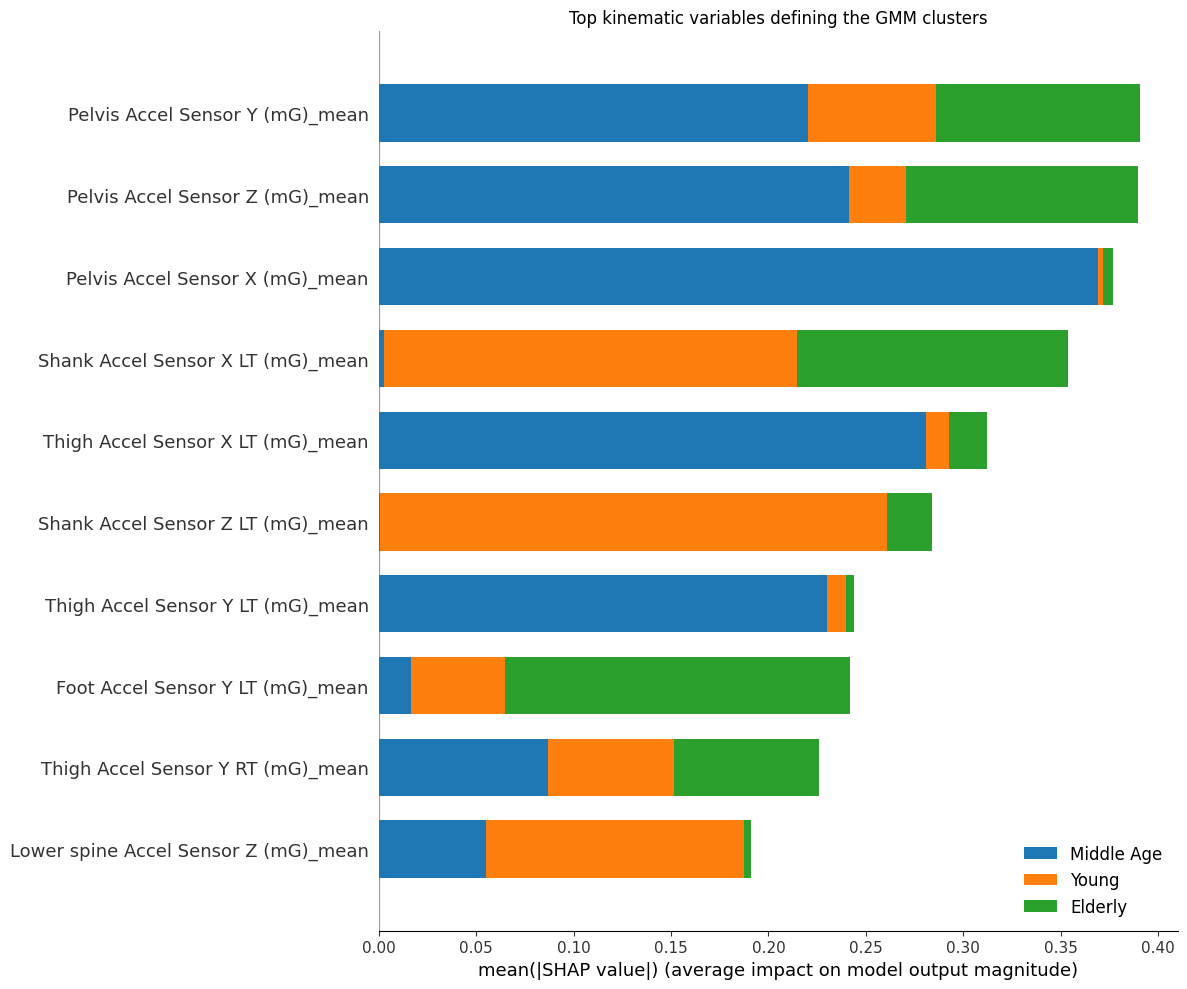

In [8]:
# Train XGBoost to predict GMM labels from engineered features
seed = 42
np.random.seed(seed)
# 1. Train Proxy Model
print("Training XGBoost to replicate GMM clusters...")
model_proxy = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    n_jobs=-1,
    random_state=seed,
    subsample=1.0,            
    colsample_bytree=1.0,    
    objective='multi:softprob',
    num_class=3
)

# Train with statistical features and GMM labels
model_proxy.fit(X_df, gmm_labels)

acc = model_proxy.score(X_df, gmm_labels)
print(f"Proxy accuracy (should be high > 0.90): {acc:.4f}")

# 2. Compute SHAP values
# Use a subsample if you have many data points (e.g., 5000) so it doesn’t take too long
print("Computing SHAP values...")
# Take a representative sample to speed up computation
X_sample = X_df.sample(n=min(5000, len(X_df)), random_state=42) 
explainer = shap.TreeExplainer(model_proxy)
shap_values = explainer.shap_values(X_sample)

# 3. Visualize Global Ranking
classes_names = ["Young", "Middle Age", "Elderly"]
mis_colores = ['#1f77b4', '#ff7f0e', '#2ca02c']
cmap_shap = ListedColormap(mis_colores)
plt.figure(figsize=(12, 10))
plt.title("Top kinematic variables defining the GMM clusters")
shap.summary_plot(
    shap_values, 
    X_sample, 
    plot_type="bar", 
    max_display=10,
    show=False,
    class_names=classes_names,
    color=cmap_shap
)

plt.gcf().set_size_inches(12, 10)  
plt.subplots_adjust(bottom=0.2)
plt.tight_layout()
plt.show()



Total original names detected: 321
Example of the first 3: ['time', 'Pelvis Accel Sensor X (mG)', 'Pelvis Accel Sensor Y (mG)']
feature_importances shape (should be (963,)): (963,)


/tmp/ipykernel_2301274/4006641961.py:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_sorted, y='Variable', x='Importance', palette='viridis')


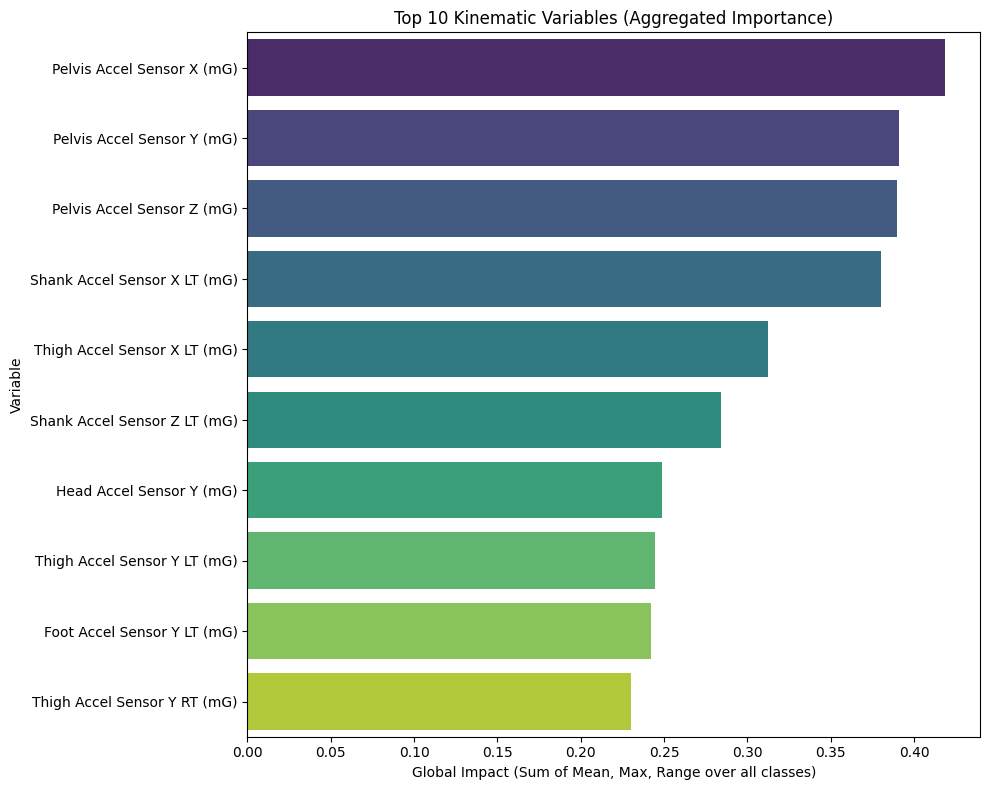


=== TOP 3 MOST DISCRIMINATIVE VARIABLES ===
Pelvis Accel Sensor X (mG) (Score: 0.4186)
Pelvis Accel Sensor Y (mG) (Score: 0.3906)
Pelvis Accel Sensor Z (mG) (Score: 0.3898)


In [9]:
# Identify top original variables by aggregating SHAP importances
# =============================================================================
# 1. NAME CHECK (Crucial)
# =============================================================================
# First, make sure the original names were loaded correctly
print(f"Total original names detected: {len(col_names_original)}")
print(f"Example of the first 3: {col_names_original[:3]}")
# If here you see ['Var_0', 'Var_1'...] check the path to your .txt file

# =============================================================================
# 2. COMPUTE ROBUST IMPORTANCE (Error correction)
# =============================================================================

# Step A: Flatten SHAP structure to a single importance vector (963,)
# ---------------------------------------------------------------------
if isinstance(shap_values, list):
    # MULTICLASS CASE (List of arrays): [Array(N, 963), Array(N, 963), Array(N, 963)]
    # 1. Compute mean absolute value per column for each class -> 3 arrays of shape (963,)
    class_importances = [np.abs(s).mean(axis=0) for s in shap_values]
    # 2. Sum the importances across the 3 classes -> 1 array of shape (963,)
    feature_importances = np.sum(class_importances, axis=0)

elif len(shap_values.shape) == 3:
    # 3D ARRAY CASE: (N, 963, 3) - Depends on SHAP version
    # Mean over axis 0 (samples), sum over axis 2 (classes)
    feature_importances = np.abs(shap_values).mean(axis=0).sum(axis=-1)

else:
    # BINARY OR STANDARD CASE: (N, 963)
    feature_importances = np.abs(shap_values).mean(axis=0)

# Safety check (so it doesn’t fail again)
print(f"feature_importances shape (should be (963,)): {feature_importances.shape}")

# Step B: Sum Mean + Max + Range per original variable
# ---------------------------------------------------------------------
n_vars = 321
aggregated_importance = []

# Make sure col_names_original has the correct length
if len(col_names_original) != n_vars:
    print(f"⚠️ Warning: You have {len(col_names_original)} names but 321 are expected.")
    # Emergency adjustment to avoid index error
    col_names_original = col_names_original[:n_vars] 

for i in range(n_vars):
    # Indices in the extended 963-feature vector
    idx_mean  = i
    idx_max   = i + n_vars
    idx_range = i + (2 * n_vars)
    
    # Extract values and make sure they are floats, not 1-element arrays
    val_mean  = float(feature_importances[idx_mean])
    val_max   = float(feature_importances[idx_max])
    val_range = float(feature_importances[idx_range])
    
    # Total sum for that physical variable
    total_imp = val_mean + val_max + val_range
    aggregated_importance.append(total_imp)

# =============================================================================
# 3. PLOT CLEAN RANKING
# =============================================================================

df_importance = pd.DataFrame({
    'Variable': col_names_original, 
    'Importance': aggregated_importance
})

# Now it will work because 'Importance' are pure floats
df_sorted = df_importance.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10, 8))
sns.barplot(data=df_sorted, y='Variable', x='Importance', palette='viridis')
plt.title("Top 10 Kinematic Variables (Aggregated Importance)")
plt.xlabel("Global Impact (Sum of Mean, Max, Range over all classes)")
plt.tight_layout()
plt.show()

print("\n=== TOP 3 MOST DISCRIMINATIVE VARIABLES ===")
for idx, row in df_sorted.head(3).iterrows():
    print(f"{row['Variable']} (Score: {row['Importance']:.4f})")


In [10]:
#Find the Biomarkers 

def plot_standard_scaler(variable_name, loader, name_list, scaler):
    # 1. Clean name and find index
    clean_name = variable_name.split(" (Score:")[0]
    try:
        idx = name_list.index(clean_name)
    except ValueError:
        print(f"Could not find '{clean_name}'")
        return

    # 2. Get Mean and Std from the Scaler
    try:
        # Attempt to access StandardScaler attributes
        if hasattr(scaler, 'mean_') and hasattr(scaler, 'scale_'):
            mean_val = scaler.mean_[idx]
            std_val = scaler.scale_[idx]
            print(f"StandardScaler detected correctly.")
            print(f"   Variable: {clean_name}")
            print(f"   Mean: {mean_val:.2f}, Std: {std_val:.2f}")
        
        # In case the scaler was saved as a dictionary
        elif isinstance(scaler, dict) and 'mean_' in scaler:
            mean_val = scaler['mean_'][idx]
            std_val = scaler['scale_'][idx]
            print(f"StandardScaler dictionary detected.")
        else:
            print("The object does not appear to be a StandardScaler. Check if you loaded the correct .pkl.")
            # Safe fallback so the function does not break
            mean_val, std_val = 0, 1
            
    except IndexError:
        print("Scaler does not match the expected number of variables (321).")
        return

    # 3. Collect data (Ant Loop)
    print("Extracting data...")
    data_list = []
    group_list = []
    
    for x_batch, meta in loader:
        col = x_batch[:, :, idx].numpy()
        g = meta[:, 0, 1].long().numpy()  # True labels 1, 2, 3
        data_list.append(col)
        group_list.append(g)
    
    X_all = np.concatenate(data_list, axis=0)
    y_all = np.concatenate(group_list, axis=0)

    # 4. STANDARD DE-NORMALIZATION
    # Formula: Real = (Norm * Std) + Mean
    X_real = (X_all * std_val) + mean_val

    # 5. Plot
    legend_map = {1: 'Young (G01)', 2: 'Middle Age(G02)', 3: 'Elderly (G03)'}
    colors = {
    1: mis_colores[0], # Blue for Young
    2: mis_colores[1], # Orange for Middle Age
    3: mis_colores[2]  # green for Elderly
}

    plt.figure(figsize=(10, 6))
    
    for g_id in [1, 2, 3]:
        mask = (y_all == g_id)
        group_data = X_real[mask]
        
        if len(group_data) > 0:
            mean_curve = np.mean(group_data, axis=0)
            std_curve = np.std(group_data, axis=0)
            label = f"{legend_map[g_id]} (n={len(group_data)})"
            
            plt.plot(mean_curve, color=colors[g_id], linewidth=3, label=label)
            # Variability shading
            plt.fill_between(
                range(100), 
                mean_curve - std_curve, 
                mean_curve + std_curve, 
                color=colors[g_id], alpha=0.15
            )

    plt.axvline(60, color='gray', linestyle='--', label='Toe-off')
    
    # Units
    unit = "Value"
    if "deg" in clean_name: 
        unit = "Degrees (°)"
    elif "Accel" in clean_name: 
        unit = "Acceleration (mG)"

    plt.title(f"Real Kinematics: {clean_name}", fontsize=14)
    plt.xlabel("% Gait Cycle")
    plt.ylabel(unit)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()





StandardScaler detected correctly.
   Variable: Pelvis Accel Sensor X (mG)
   Mean: 962.03, Std: 301.80
Extracting data...


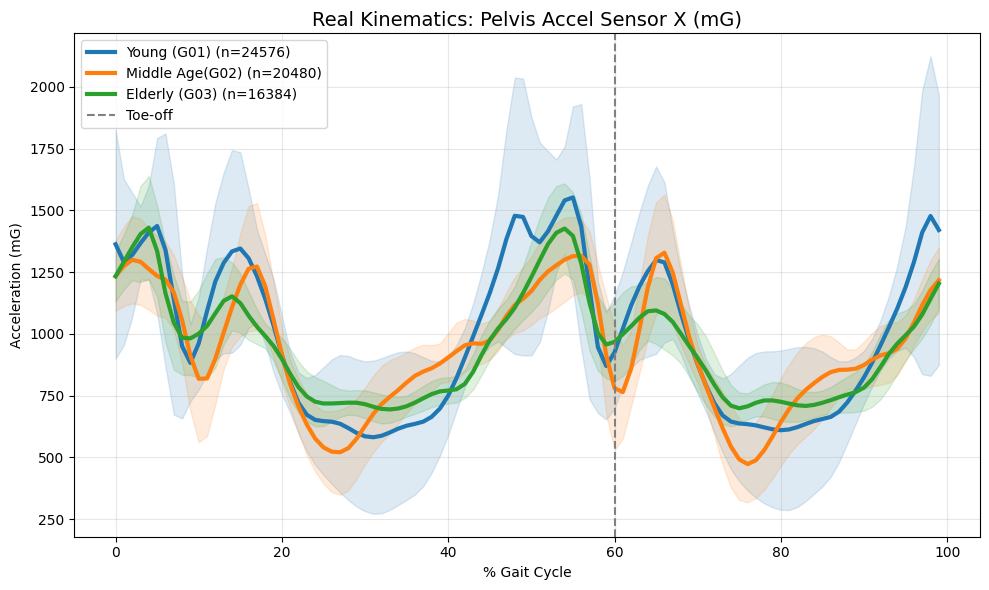

In [11]:
#Plot comparativo de la variable original desnormalizada
mi_scaler = joblib.load('global_kinematic_scaler_zscore.pkl') 

plot_standard_scaler(
    "Pelvis Accel Sensor X (mG)",
    test_loader,
    name_list=col_names_original,
    scaler=mi_scaler
)


StandardScaler detected correctly.
   Variable: Pelvis Accel Sensor Y (mG)
   Mean: 10.17, Std: 239.51
Extracting data...


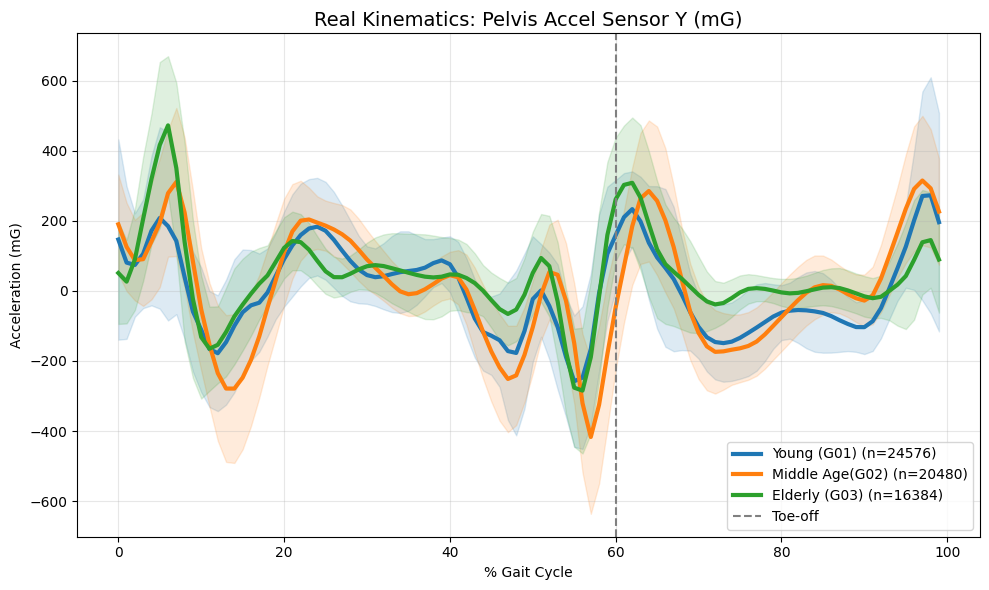

In [16]:
#Plot comparativo de la variable original desnormalizada
mi_scaler = joblib.load('global_kinematic_scaler_zscore.pkl') 

plot_standard_scaler(
    "Pelvis Accel Sensor Y (mG)",
    test_loader,
    name_list=col_names_original,
    scaler=mi_scaler
)



StandardScaler detected correctly.
   Variable: Pelvis Accel Sensor Z (mG)
   Mean: 224.64, Std: 297.71
Extracting data...


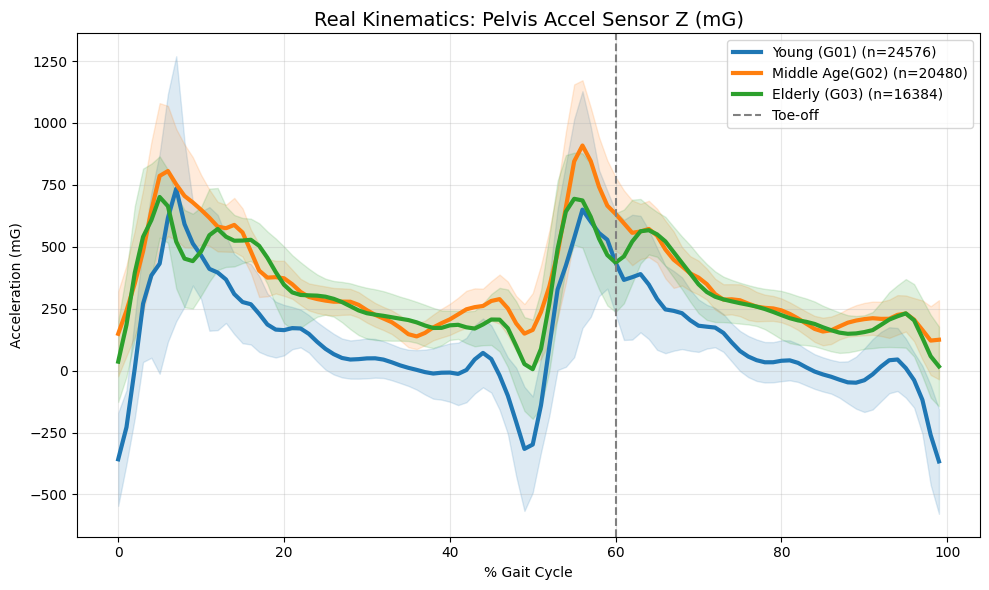

In [17]:
#Plot comparativo de la variable original desnormalizada
mi_scaler = joblib.load('global_kinematic_scaler_zscore.pkl') 

plot_standard_scaler(
    "Pelvis Accel Sensor Z (mG)",
    test_loader,
    name_list=col_names_original,
    scaler=mi_scaler
)




## HDBSCAN 

In [12]:
#Find indices of specific variables
def find_indices(keyword, names):
    return [i for i, n in enumerate(names) if keyword.lower() in n.lower()]

idx_HipFlexion  = find_indices("Pelvis Accel Sensor X (mG)", col_names_original)[0]
idx_ShankAccelX   = find_indices("Pelvis Accel Sensor Y (mG)", col_names_original)[0]
idx_ThighAccelY  = find_indices("Pelvis Accel Sensor Z (mG)", col_names_original)[0]

var_indices_of_interest = [
    idx_ShankAccelX,
    idx_HipFlexion,
    idx_ThighAccelY,
]

print(var_indices_of_interest)

[2, 1, 3]


In [13]:
#Basic cluster info
labels = HDBSCAN_labels  # (N_test,)

# Exclude noise
mask_valid = labels != -1
labels_valid = labels[mask_valid]
latents_valid = latents[mask_valid]
subjects_valid = subject_ids[mask_valid]
groups_valid   = true_groups[mask_valid]

unique_clusters, counts = np.unique(labels_valid, return_counts=True)
cluster_summary = pd.DataFrame({
    "cluster": unique_clusters,
    "n_points": counts
}).sort_values("n_points", ascending=False)

print(cluster_summary)



    cluster  n_points
10       10      8038
9         9      7882
11       11      7018
18       18      6448
17       17      6182
8         8      5962
12       12      5854
7         7      2992
19       19      2737
1         1      2318
15       15      1990
4         4       685
0         0       470
2         2       268
16       16       226
13       13       162
6         6       122
5         5       118
14       14       117
3         3       116


In [14]:
#Identify cluster composition

df = pd.DataFrame({
    "cluster": HDBSCAN_labels,
    "group": true_groups  # 0=Young, 1=Middle, 2=Elderly
})

df_valid = df[df["cluster"] != -1]

cluster_group_counts = (
    df_valid
    .groupby(["cluster", "group"])
    .size()
    .unstack(fill_value=0)
)

cluster_group_counts["total"] = cluster_group_counts.sum(axis=1)

# Remove 'total' before computing predominant group
cluster_group_counts["predominant_group"] = (
    cluster_group_counts.drop(columns=["total"]).idxmax(axis=1)
)

cluster_group_counts



group       1     2     3  total predominant_group
cluster                                           
0         470     0     0    470                 1
1           0  2318     0   2318                 2
2         268     0     0    268                 1
3         116     0     0    116                 1
4           0   685     0    685                 2
5           0   118     0    118                 2
6         122     0     0    122                 1
7           0     0  2992   2992                 3
8           0     0  5962   5962                 3
9           0  7882     0   7882                 2
10       8038     0     0   8038                 1
11          0     0  7018   7018                 3
12          0  5854     0   5854                 2
13          0   162     0    162                 2
14          0   117     0    117                 2
15       1990     0     0   1990                 1
16        226     0     0    226                 1
17       6182     0     0   6182                 1
18       6448     0     0   6448                 1
19          0  2737     0   2737                 2

In [15]:
#Calcular cluster_means y cluster_counts
# Unique clusters excluding noise
unique_clusters = np.unique(labels[labels != -1])

# Número de variables de interés y de puntos temporales
n_vars = len(var_indices_of_interest)
T = 100  # longitud del ciclo normalizado

# Initialize containers for cluster means and counts
cluster_means = {
    c: np.zeros((n_vars, T), dtype=np.float64)
    for c in unique_clusters
}
cluster_counts = {c: 0 for c in unique_clusters}

# Precompute for fast membership: we already have labels aligned with test_loader order
global_idx = 0

model.eval()
with torch.no_grad():
    for x_batch, meta in test_loader:
        B, T_batch, C = x_batch.shape  # (B, 100, C_total)
        x_cpu = x_batch[:, :, :321].cpu().numpy()  # (B, 100, 321)

        # Labels for this batch in global order
        batch_labels = labels[global_idx: global_idx + B]  # (B,)

        for i in range(B):
            label = batch_labels[i]
            if label == -1:
                continue  # skip noise

            c = label  # cluster id

            # Accumulate means for each variable of interest
            for j, v_idx in enumerate(var_indices_of_interest):
                # x_cpu[i, :, v_idx] has shape (T,)
                cluster_means[c][j] += x_cpu[i, :, v_idx]

            cluster_counts[c] += 1

        global_idx += B  # advance global index by batch size

# Convert sums into means per cluster
for c in unique_clusters:
    if cluster_counts[c] > 0:
        cluster_means[c] /= cluster_counts[c]


In [16]:
#Macro-perfiles por grupo (Young/Middle/Elderly) + gráficas
# Build DataFrame of (cluster, group) without noise
df = pd.DataFrame({
    "cluster": labels,
    "group": true_groups
})
df_valid = df[df["cluster"] != -1]

cluster_group_counts = (
    df_valid
    .groupby(["cluster", "group"])
    .size()
    .unstack(fill_value=0)
)

cluster_group_counts["total"] = cluster_group_counts.sum(axis=1)
cluster_group_counts["predominant_group"] = (
    cluster_group_counts.drop(columns=["total"]).idxmax(axis=1)
)

print(cluster_group_counts)


group       1     2     3  total predominant_group
cluster                                           
0         470     0     0    470                 1
1           0  2318     0   2318                 2
2         268     0     0    268                 1
3         116     0     0    116                 1
4           0   685     0    685                 2
5           0   118     0    118                 2
6         122     0     0    122                 1
7           0     0  2992   2992                 3
8           0     0  5962   5962                 3
9           0  7882     0   7882                 2
10       8038     0     0   8038                 1
11          0     0  7018   7018                 3
12          0  5854     0   5854                 2
13          0   162     0    162                 2
14          0   117     0    117                 2
15       1990     0     0   1990                 1
16        226     0     0    226                 1
17       6182     0     0   618

In [17]:
#Ahora sacamos los clusters de cada grupo:
# Assuming groups are encoded as 1=Young, 2=Middle, 3=Elderly
young_clusters   = cluster_group_counts[cluster_group_counts["predominant_group"] == 1].index.tolist()
middle_clusters  = cluster_group_counts[cluster_group_counts["predominant_group"] == 2].index.tolist()
elderly_clusters = cluster_group_counts[cluster_group_counts["predominant_group"] == 3].index.tolist()

print("Young clusters:  ", young_clusters)
print("Middle clusters: ", middle_clusters)
print("Elderly clusters:", elderly_clusters)


Young clusters:   [0, 2, 3, 6, 10, 15, 16, 17, 18]
Middle clusters:  [1, 4, 5, 9, 12, 13, 14, 19]
Elderly clusters: [7, 8, 11]


In [18]:
#Macro-perfiles (promedio ponderado por #ciclos) 
# Initialize macro means weighted by number of strides per cluster
macro_sum = {
    1: np.zeros((n_vars, T), dtype=np.float64),  # Young
    2: np.zeros((n_vars, T), dtype=np.float64),  # Middle
    3: np.zeros((n_vars, T), dtype=np.float64),  # Elderly
}
macro_counts = {1: 0, 2: 0, 3: 0}

# Helper: iterate clusters and assign to group
for c in unique_clusters:
    predominant_group = cluster_group_counts.loc[c, "predominant_group"]
    g = int(predominant_group)  # 1,2,3

    # Weighted sum: cluster_mean * number of strides in that cluster
    macro_sum[g] += cluster_means[c] * cluster_counts[c]
    macro_counts[g] += cluster_counts[c]

# Compute final macro means per group
macro_mean = {}
for g in [1, 2, 3]:
    if macro_counts[g] > 0:
        macro_mean[g] = macro_sum[g] / macro_counts[g]
    else:
        macro_mean[g] = np.zeros((n_vars, T), dtype=np.float64)


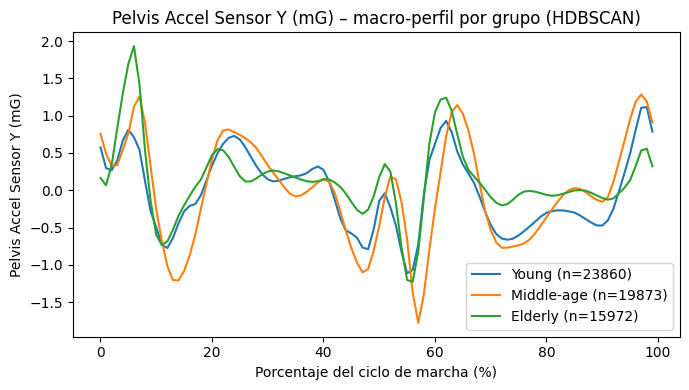

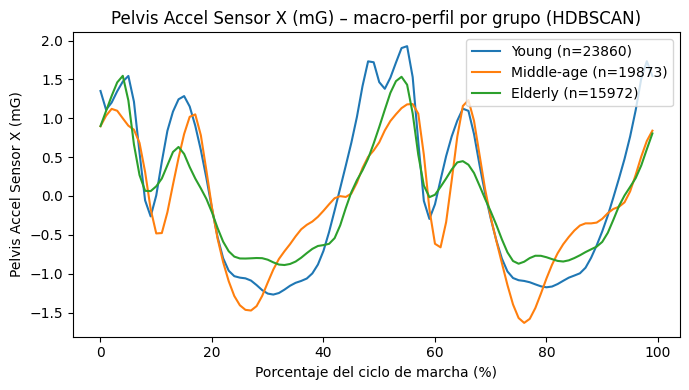

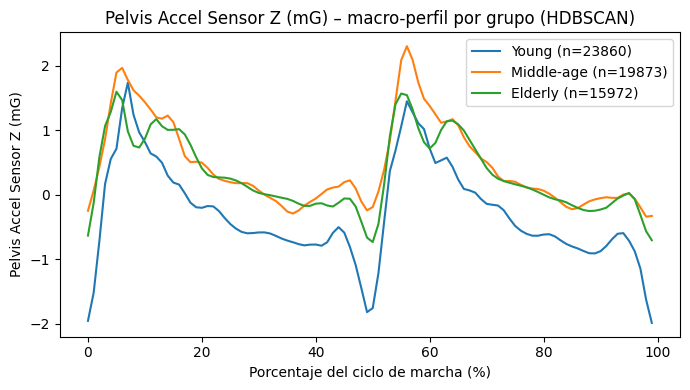

In [19]:
# Macro-profile plots
import matplotlib.pyplot as plt

group_names = {1: "Young", 2: "Middle-age", 3: "Elderly"}
group_colors = {1: "tab:blue", 2: "tab:orange", 3: "tab:green"}

def plot_macro_profiles(var_indices_of_interest, macro_mean, col_names_original):
    """
    Plot macro-profiles Young vs Middle vs Elderly for the given variables.
    """
    n_vars = len(var_indices_of_interest)
    T = macro_mean[1].shape[1]  # 100

    for j, v_idx in enumerate(var_indices_of_interest):
        var_name = col_names_original[v_idx]

        plt.figure(figsize=(7, 4))
        for g in [1, 2, 3]:
            curve = macro_mean[g][j]  # (T,)
            plt.plot(curve, label=f"{group_names[g]} (n={macro_counts[g]})",
                     color=group_colors[g])

        plt.title(f"{var_name} – macro-perfil por grupo (HDBSCAN)")
        plt.xlabel("Porcentaje del ciclo de marcha (%)")
        plt.ylabel(var_name)
        plt.legend()
        plt.tight_layout()
        plt.show()

# Llamar a la función
plot_macro_profiles(var_indices_of_interest, macro_mean, col_names_original)


In [ ]:
# % reduction in Pelvis Accel Range between Young and Elderly
import numpy as np

# 1. Variables de Pelvis (Range)
vars_pelvis = [
    'Pelvis Accel Sensor X (mG)_range', 
    'Pelvis Accel Sensor Y (mG)_range', 
    'Pelvis Accel Sensor Z (mG)_range'
]

# 2. Filtrar por grupos (1=Young, 3=Elderly) - Ajusta IDs si es necesario
# Nota: true_groups debe estar alineado con X_df
young_data = X_df.loc[true_groups == 1, vars_pelvis]
elderly_data = X_df.loc[true_groups == 3, vars_pelvis]

# 3. Calcular promedios
mean_young = young_data.mean().mean() # Promedio de los 3 ejes
mean_elderly = elderly_data.mean().mean()

# 4. Calcular % de reducción
reduccion = ((mean_young - mean_elderly) / mean_young) * 100

print(f"Promedio Rango Young: {mean_young:.2f}")
print(f"Promedio Rango Elderly: {mean_elderly:.2f}")
print(f"⬇️ PORCENTAJE DE REDUCCIÓN: {reduccion:.1f}%")

Promedio Rango Young: 4.77
Promedio Rango Elderly: 3.62
⬇️ PORCENTAJE DE REDUCCIÓN: 24.0%


In [21]:
# % reduction in Hip Flexion Range between Young and Elderly
hip_var = 'Hip Flexion RT (deg)_range' # Asegúrate del nombre exacto en tu X_df

if hip_var in X_df.columns:
    young_hip = X_df.loc[true_groups == 1, hip_var].mean()
    elderly_hip = X_df.loc[true_groups == 3, hip_var].mean()
    
    red_hip = ((young_hip - elderly_hip) / young_hip) * 100
    print(f"Reducción Hip Flexion: {red_hip:.1f}%")
else:
    print("Verifica el nombre de la variable de cadera en X_df.columns")

Reducción Hip Flexion: 1.8%


In [27]:
# Latent dispersion per groups 

def latent_spread(latents, groups, group_id):
    Z = latents[groups == group_id]
    center = Z.mean(axis=0)
    dists = np.linalg.norm(Z - center, axis=1)
    return dists.mean(), dists.std()

for g in [1,2,3]:
    mean_dist, std_dist = latent_spread(latents, true_groups, g)
    print(f"Group {g}: mean dist={mean_dist:.3f}, std={std_dist:.3f}")


Group 1: mean dist=8.108, std=0.884
Group 2: mean dist=7.564, std=1.485
Group 3: mean dist=7.857, std=0.829


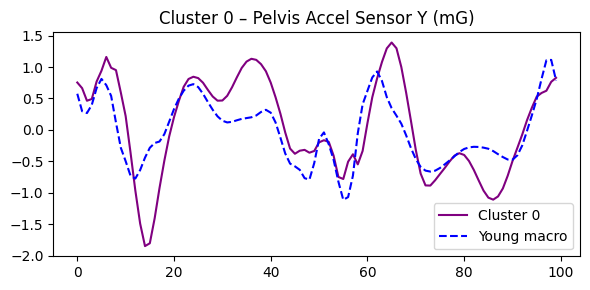

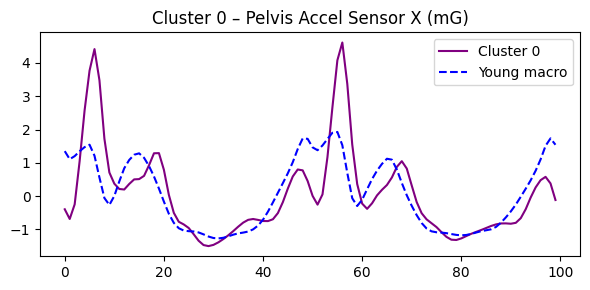

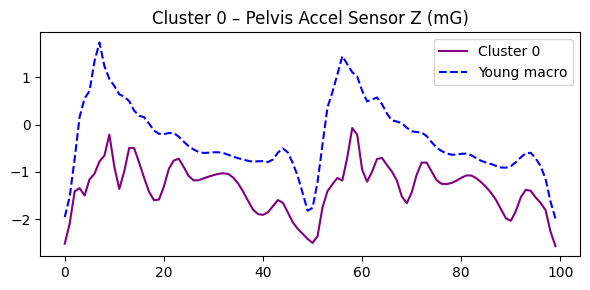

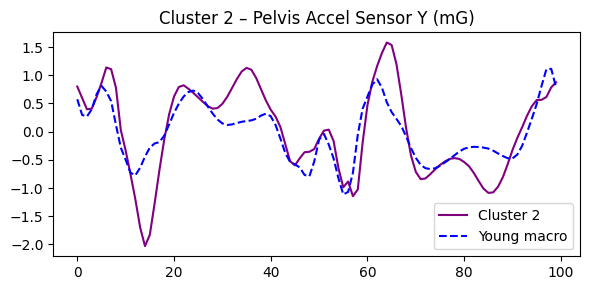

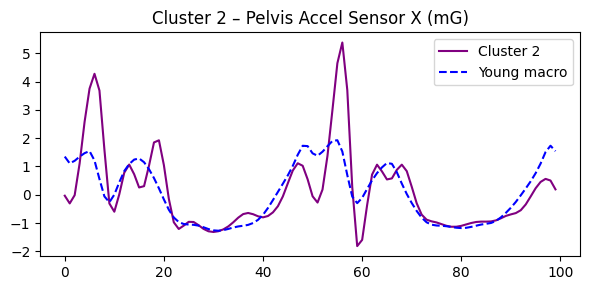

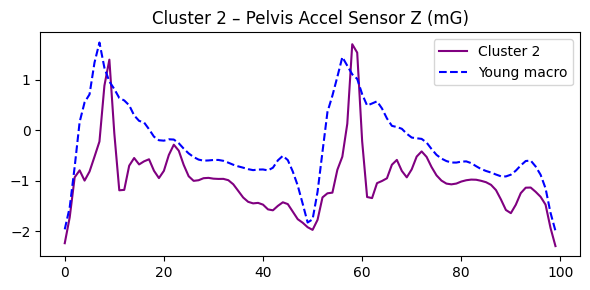

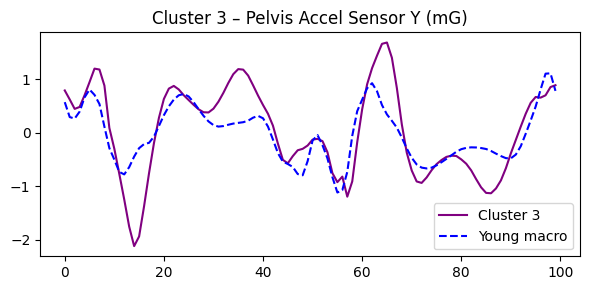

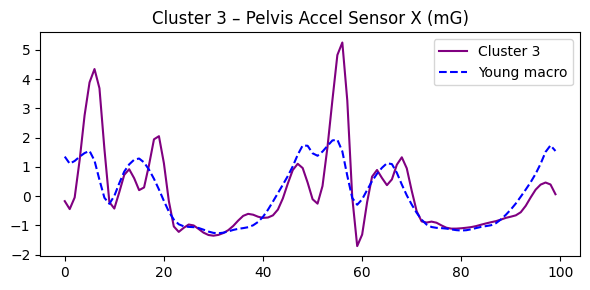

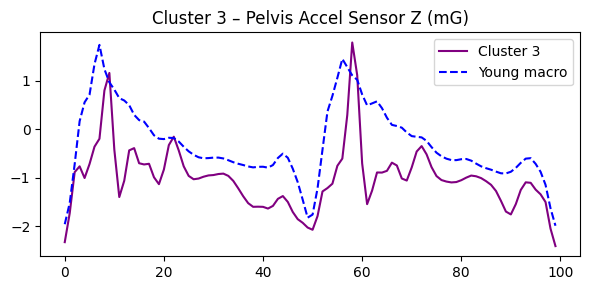

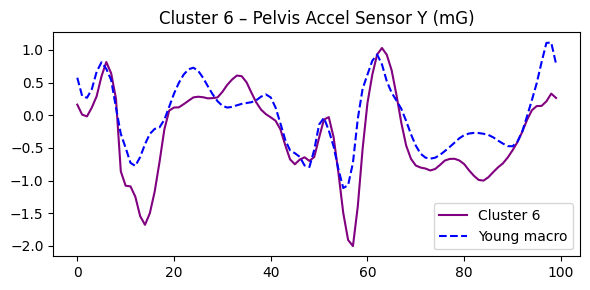

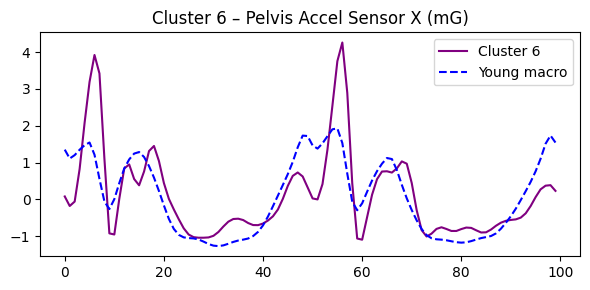

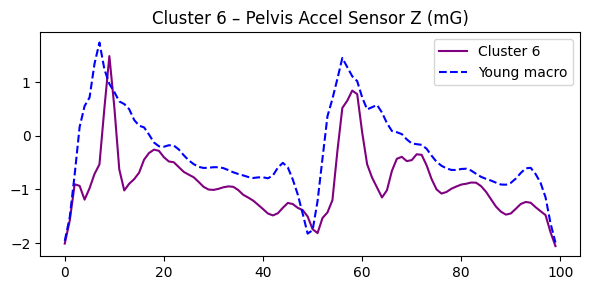

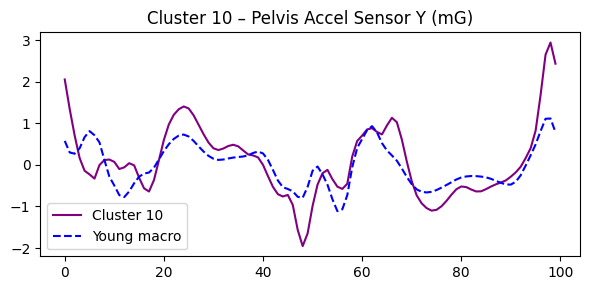

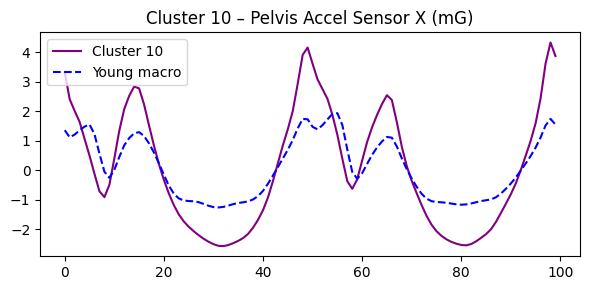

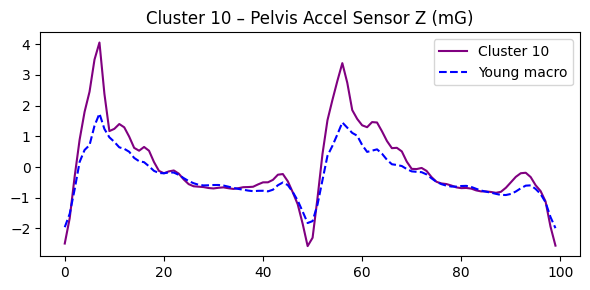

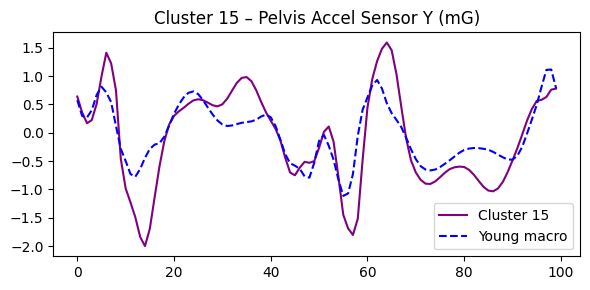

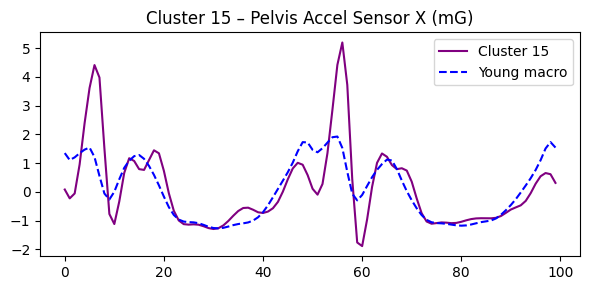

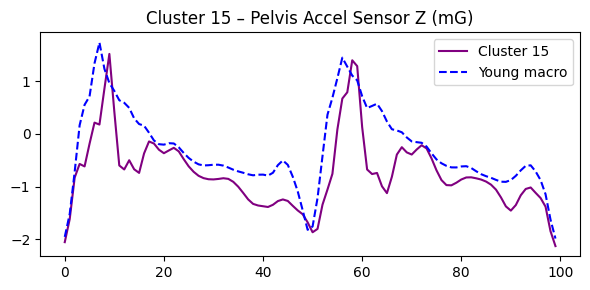

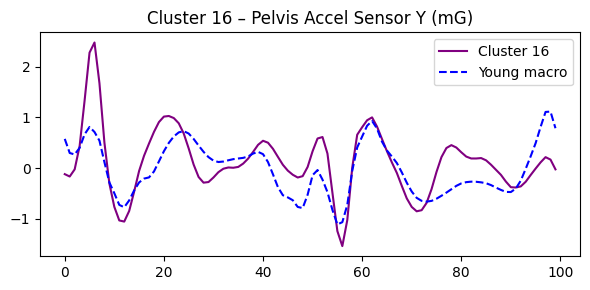

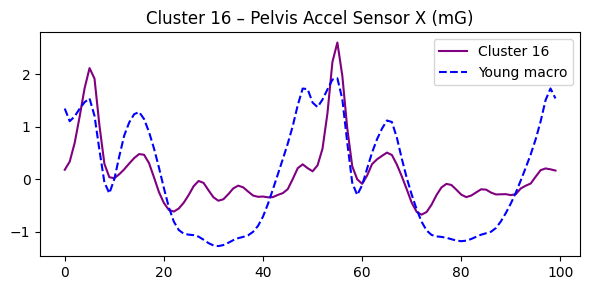

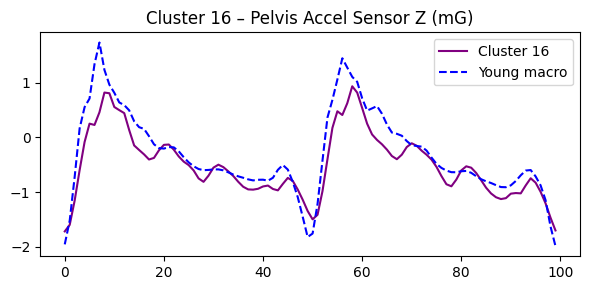

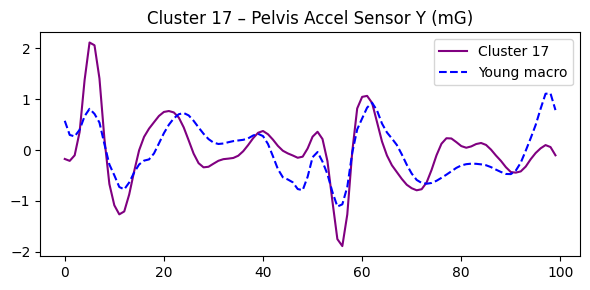

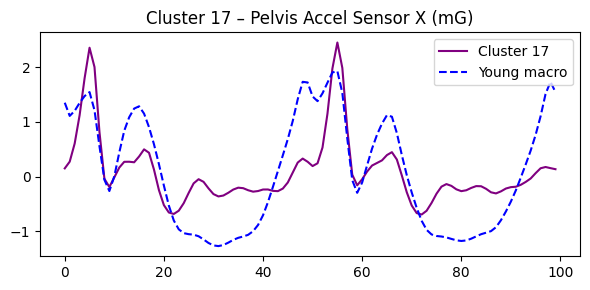

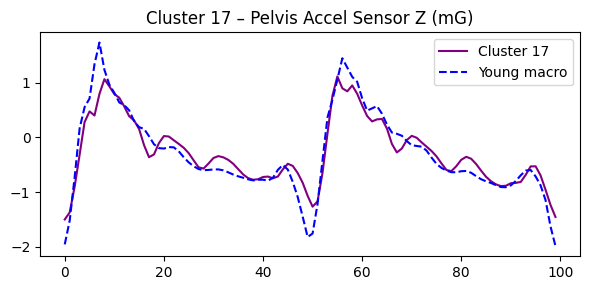

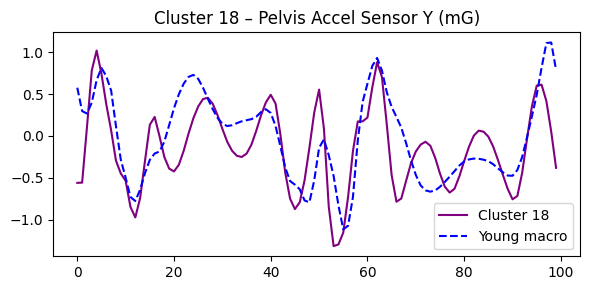

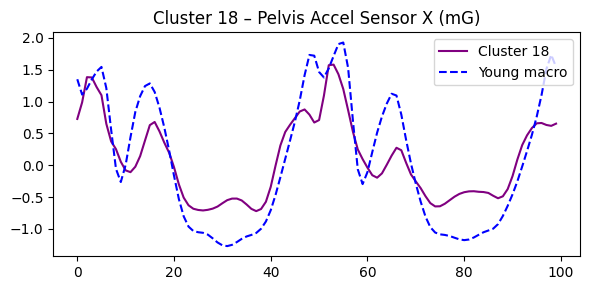

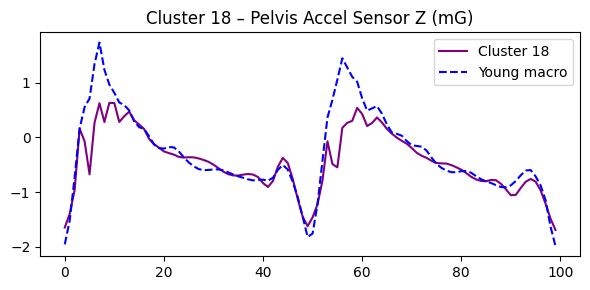

In [28]:
# for each young cluster plot vs young macro-profile
for c in young_clusters:
    for j, v_idx in enumerate(var_indices_of_interest):
        plt.figure(figsize=(6,3))
        plt.plot(cluster_means[c][j], label=f"Cluster {c}", color="purple")
        plt.plot(macro_mean[1][j], label="Young macro", color="blue", linestyle="--")
        plt.title(f"Cluster {c} – {col_names_original[v_idx]}")
        plt.legend()
        plt.tight_layout()
        plt.show()


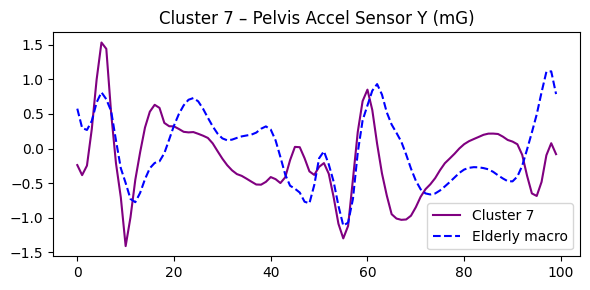

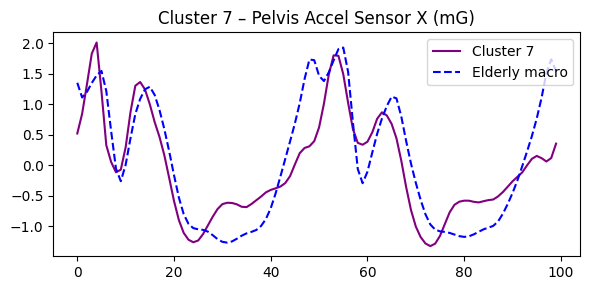

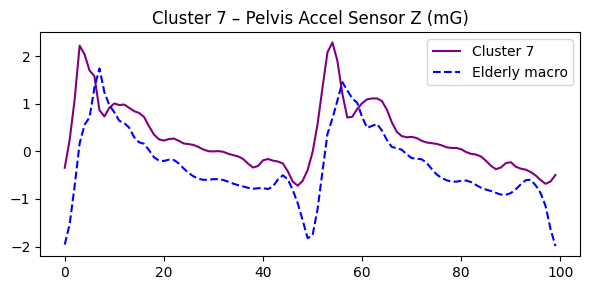

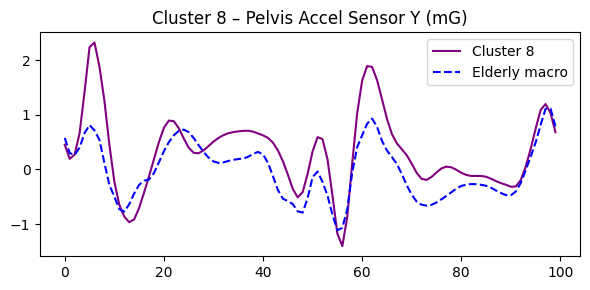

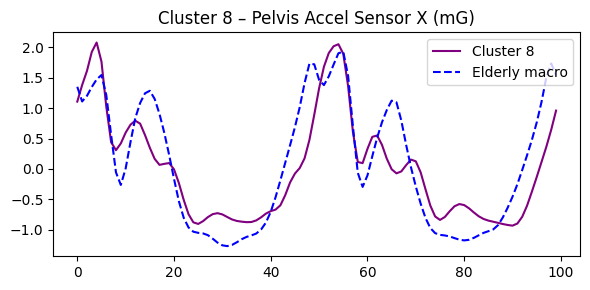

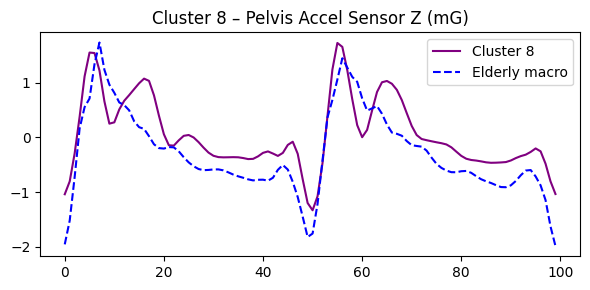

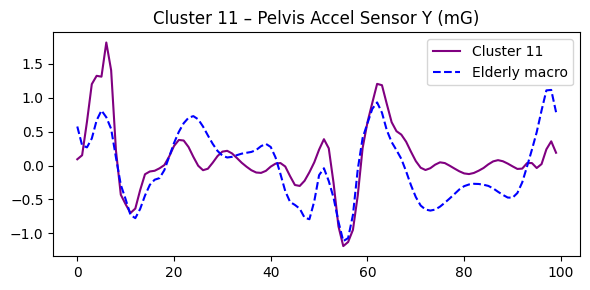

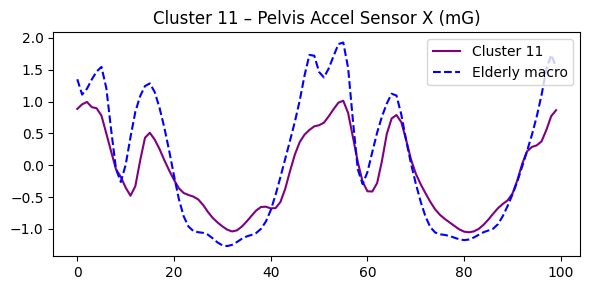

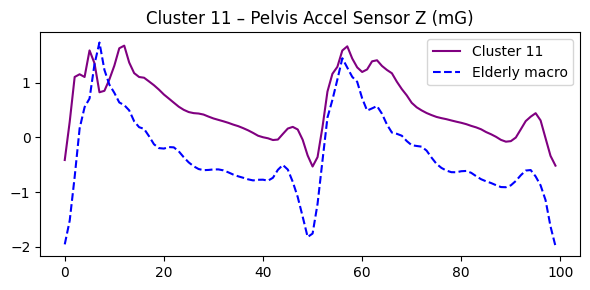

In [ ]:
# for each eldery cluster plot vs macro-profile
for c in elderly_clusters:
    for j, v_idx in enumerate(var_indices_of_interest):
        plt.figure(figsize=(6,3))
        plt.plot(cluster_means[c][j], label=f"Cluster {c}", color="purple")
        plt.plot(macro_mean[1][j], label="Elderly macro", color="blue", linestyle="--")
        plt.title(f"Cluster {c} – {col_names_original[v_idx]}")
        plt.legend()
        plt.tight_layout()
        plt.show()

In [ ]:
# for each middle age cluster plot vs young macro-profile
for c in middle_clusters:
    for j, v_idx in enumerate(var_indices_of_interest):
        plt.figure(figsize=(6,3))
        plt.plot(cluster_means[c][j], label=f"Cluster {c}", color="purple")
        plt.plot(macro_mean[1][j], label="Middle macro", color="blue", linestyle="--")
        plt.title(f"Cluster {c} – {col_names_original[v_idx]}")
        plt.legend()
        plt.tight_layout()
        plt.show()

In [31]:
def compare_young_vs_elder_var(j, var_idx):

    var_name = col_names_original[var_idx]

    plt.figure(figsize=(8,4))

    # Elderly macro
    plt.plot(macro_mean[3][j], label="Elderly macro", color="green", linewidth=2)

    # Elderly subclusters
    for c in elderly_clusters:
        plt.plot(cluster_means[c][j], label=f"Elderly c{c}", alpha=0.4, color="green")

    # Young macro
    plt.plot(macro_mean[1][j], label="Young macro", color="blue", linewidth=2)

    # Young top 2 most different clusters
    for c in young_clusters[:2]:
        plt.plot(cluster_means[c][j], alpha=0.4, color="blue")

    plt.title(f"{var_name} – Young vs Elderly")
    plt.xlabel("% gait cycle")
    plt.ylabel(var_name)
    plt.legend()
    plt.tight_layout()
    plt.show()


## UMAP 

In [32]:
# latents: shape (N, 128)
# labels:  HDBSCAN_labels (N,)
# groups:  1=Young, 2=Middle, 3=Elderly (N,)
import umap
reducer = umap.UMAP(
    n_components=2,
    n_neighbors=30,      # puedes ajustar
    min_dist=0.1,        # controla dispersión
    metric="euclidean",
    random_state=42
)

embedding = reducer.fit_transform(latents)  # shape (N, 2)
print("UMAP embedding shape:", embedding.shape)


/home/dmartinez/miniconda3/envs/gait_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP embedding shape: (61440, 2)


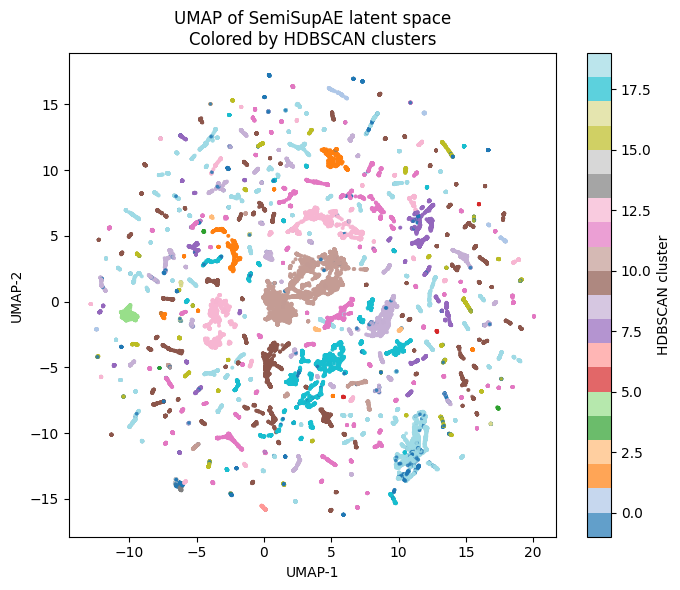

In [33]:
# Paleta de colores para clusters (0..24)
# Puedes usar un cmap categórico
plt.figure(figsize=(7, 6))
sc = plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=labels,                 # colorear por cluster
    s=3,
    cmap="tab20",             # buena paleta categórica
    alpha=0.7
)
plt.colorbar(sc, label="HDBSCAN cluster")
plt.title("UMAP of SemiSupAE latent space\nColored by HDBSCAN clusters")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()
plt.show()


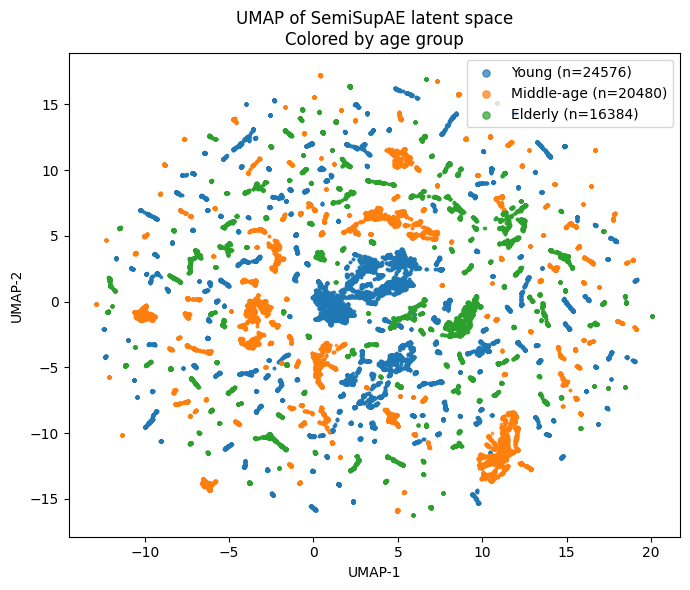

In [34]:
group_names  = {1: "Young", 2: "Middle-age", 3: "Elderly"}
group_colors = {1: "tab:blue", 2: "tab:orange", 3: "tab:green"}

plt.figure(figsize=(7, 6))

for g in [1, 2, 3]:
    mask_g = (true_groups == g)
    plt.scatter(
        embedding[mask_g, 0],
        embedding[mask_g, 1],
        s=3,
        alpha=0.7,
        color=group_colors[g],
        label=f"{group_names[g]} (n={mask_g.sum()})"
    )

plt.title("UMAP of SemiSupAE latent space\nColored by age group")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(markerscale=3)
plt.tight_layout()
plt.show()


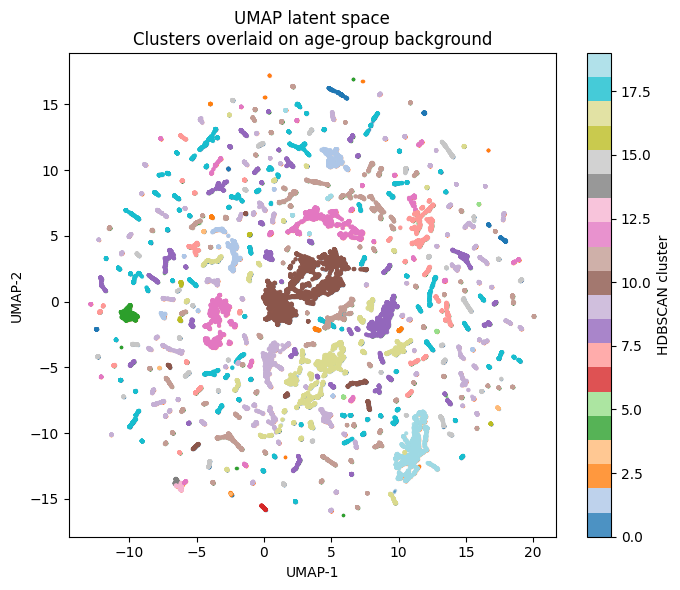

In [35]:
plt.figure(figsize=(7, 6))

# Primero, color claro por grupo
for g in [1, 2, 3]:
    mask_g = (true_groups == g)
    plt.scatter(
        embedding[mask_g, 0],
        embedding[mask_g, 1],
        s=2,
        alpha=0.15,
        color=group_colors[g],
        label=f"{group_names[g]} background"
    )

# Encima, puntos algo más grandes por cluster (sin ruido)
mask_valid = (labels != -1)
sc = plt.scatter(
    embedding[mask_valid, 0],
    embedding[mask_valid, 1],
    c=labels[mask_valid],
    s=4,
    cmap="tab20",
    alpha=0.8
)

plt.colorbar(sc, label="HDBSCAN cluster")
plt.title("UMAP latent space\nClusters overlaid on age-group background")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()
plt.show()


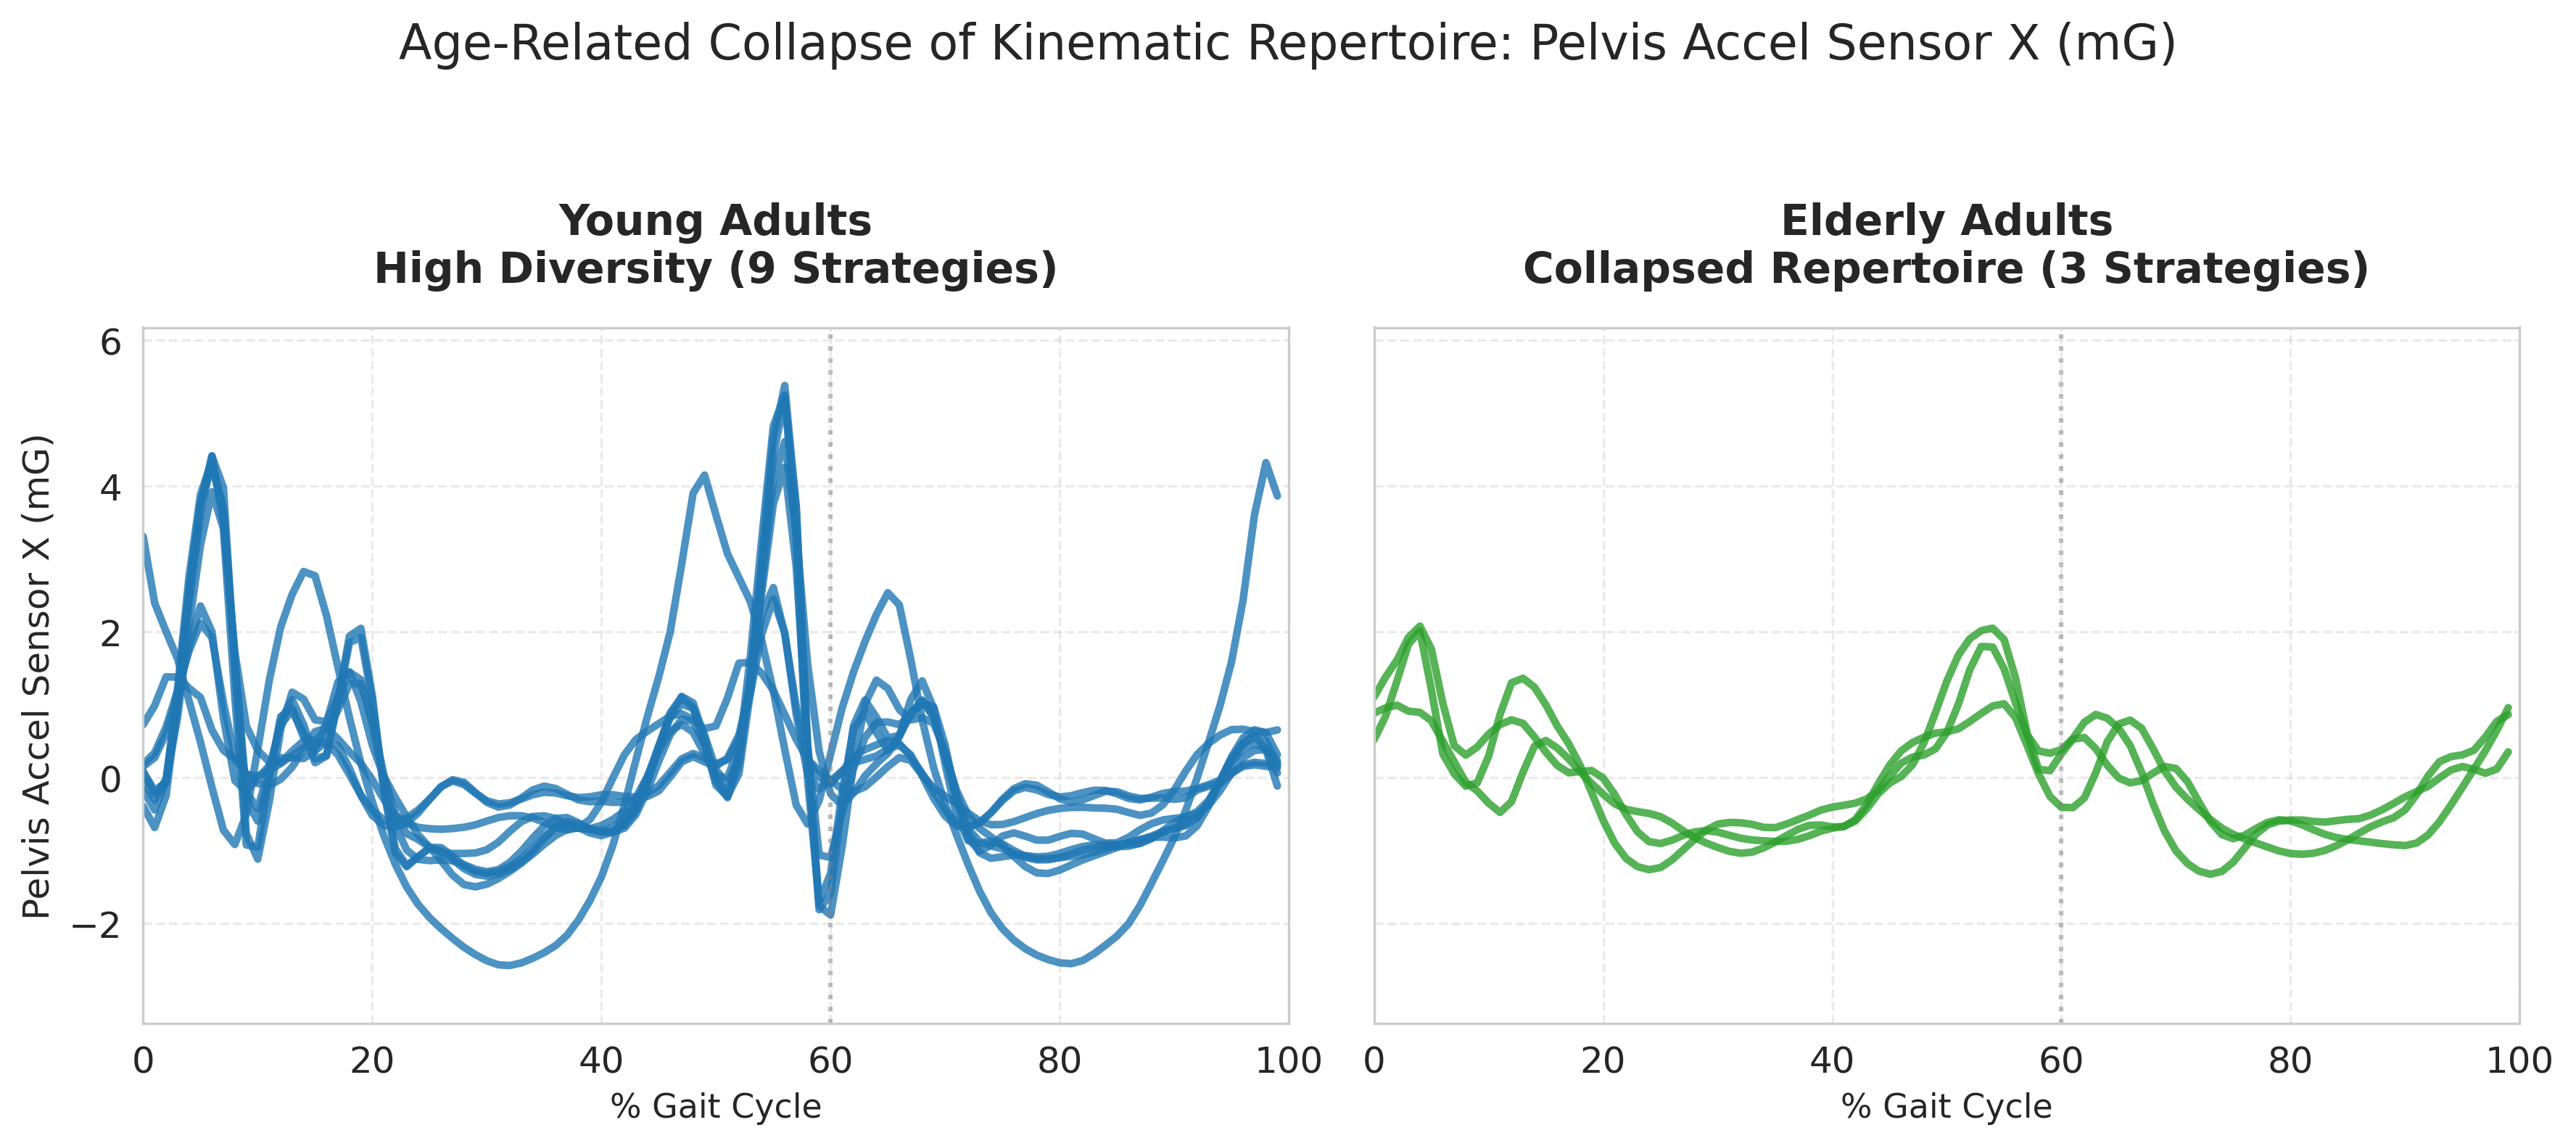

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_repertoire_collapse(var_name, var_idx, cluster_means, unique_clusters, cluster_group_counts):
    """
    Genera la figura 'Killer' para el abstract: Comparación visual del repertorio motor.
    Muestra TODAS las estrategias (clusters) de los jóvenes vs TODAS las de los ancianos.
    """
    
    # Configuración de estilo profesional
    sns.set_style("whitegrid")
    plt.rcParams.update({'font.size': 12, 'font.family': 'sans-serif'})
    
    # Crear figura de 2 paneles compartiendo eje Y para comparación honesta
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True, dpi=300)
    
    # Definir grupos a comparar (Omitimos Middle para maximizar el contraste en el abstract)
    target_groups = {
        1: {'name': 'Young Adults', 'color': 'tab:blue', 'ax': axes[0]},
        3: {'name': 'Elderly Adults', 'color': 'tab:green', 'ax': axes[1]}
    }
    
    # Rango Y global para fijar límites bonitos
    all_curves = []
    
    # --- PLOTTING ---
    counters = {1: 0, 3: 0}
    
    for c in unique_clusters:
        # Obtener grupo predominante de este cluster
        # Asumiendo que cluster_group_counts es el DF que usaste antes
        g_pred = int(cluster_group_counts.loc[c, "predominant_group"])
        
        if g_pred in target_groups:
            # Extraer la curva de la variable de interés
            curve = cluster_means[c][var_idx] # (100,)
            all_curves.append(curve)
            
            cfg = target_groups[g_pred]
            ax = cfg['ax']
            
            # Graficar la curva del cluster
            # Usamos alpha (transparencia) para que se vea la densidad
            ax.plot(curve, color=cfg['color'], linewidth=2.5, alpha=0.8, label=f"Subphenotype {c}")
            counters[g_pred] += 1

    # --- ESTÉTICA Y DETALLES ---
    # Calcular límites Y con un margen
    y_min = np.min(all_curves)
    y_max = np.max(all_curves)
    margin = (y_max - y_min) * 0.1
    
    for g_id, cfg in target_groups.items():
        ax = cfg['ax']
        count = counters[g_id]
        
        # Título con el "Insight" Biomecánico
        if g_id == 1:
            subtitle = f"{cfg['name']}\nHigh Diversity ({count} Strategies)"
        else:
            subtitle = f"{cfg['name']}\nCollapsed Repertoire ({count} Strategies)"
            
        ax.set_title(subtitle, fontsize=14, fontweight='bold', pad=15)
        ax.set_xlabel("% Gait Cycle", fontsize=11)
        
        # Línea de despegue referencial
        ax.axvline(60, color='gray', linestyle=':', alpha=0.5)
        
        # Cuadrícula suave
        ax.grid(True, linestyle='--', alpha=0.4)
        
        # Solo poner label Y en el primero
        if g_id == 1:
            ax.set_ylabel(var_name, fontsize=12)
        
        # Límites fijos
        ax.set_ylim(y_min - margin, y_max + margin)
        ax.set_xlim(0, 100)

    plt.suptitle(f"Age-Related Collapse of Kinematic Repertoire: {var_name}", fontsize=16, y=1.05)
    plt.tight_layout()
    plt.show()

# --- EJECUCIÓN ---
# Selecciona tu variable "Top 1" (ej. Hip Flexion o Pelvis Accel)
# Busca el índice en tu lista de nombres
nombre_top = "Pelvis Accel Sensor X (mG)" # O la que te haya dado mejor resultado biomecánico
idx_top = col_names_original.index(nombre_top)

# Asumiendo que 'cluster_group_counts' es el DataFrame que tiene la columna "predominant_group" indexada por cluster
plot_repertoire_collapse(nombre_top, idx_top, cluster_means, unique_clusters, cluster_group_counts)

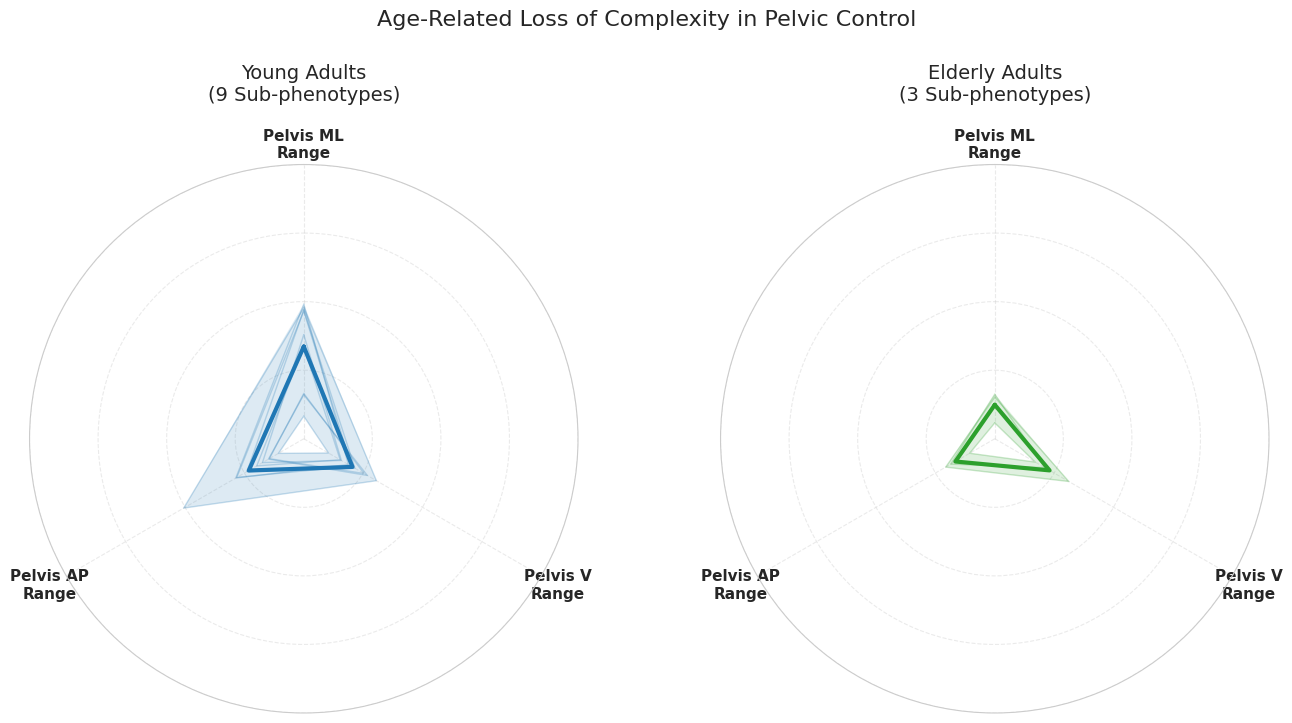

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def plot_pelvis_stability_radar(X_df, hdbscan_labels, true_groups):
    """
    Radar plots comparing pelvic control strategies across age groups.
    Variables: Pelvis Accel X, Y, Z (Range), normalised 0–1.
    """

    # 1. Variable names (Pelvis X/Y/Z range)
    top_vars = [
        'Pelvis Accel Sensor X (mG)_range',
        'Pelvis Accel Sensor Y (mG)_range',
        'Pelvis Accel Sensor Z (mG)_range'
    ]

    # Shorter labels for the plot
    display_names = [
        'Pelvis ML\nRange',
        'Pelvis V\nRange',
        'Pelvis AP\nRange'
    ]

    # Validate columns
    for col in top_vars:
        if col not in X_df.columns:
            print(f"❌ Error: '{col}' not found in X_df. Check column names.")
            return

    # 2. Data preparation
    # Remove noise (-1)
    mask = hdbscan_labels != -1

    X_clean = X_df.loc[mask, top_vars].copy()
    y_clus = hdbscan_labels[mask]
    y_age = true_groups[mask]

    # Global 0–1 normalization
    scaler = MinMaxScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X_clean), columns=top_vars)
    X_scaled["Cluster"] = y_clus
    X_scaled["AgeGroup"] = y_age

    # Cluster mean profiles
    cluster_profiles = X_scaled.groupby("Cluster")[top_vars].mean()

    # Map each cluster to its majority age group
    cluster_age_map = X_scaled.groupby("Cluster")["AgeGroup"].agg(
        lambda x: pd.Series.mode(x)[0]
    )

    # 3. Plotting setup
    angles = np.linspace(0, 2 * np.pi, len(top_vars), endpoint=False).tolist()
    angles += angles[:1]  # close loop

    fig, axes = plt.subplots(
        1, 2, figsize=(14, 7),
        subplot_kw=dict(polar=True)
    )

    groups_config = [
        {"id": 1, "name": "Young Adults",   "ax": axes[0], "color": "tab:blue"},
        {"id": 3, "name": "Elderly Adults", "ax": axes[1], "color": "tab:green"},
    ]

    for cfg in groups_config:
        ax = cfg["ax"]
        g_id = cfg["id"]

        # Clusters belonging to this age group
        clusters_in_group = cluster_age_map[cluster_age_map == g_id].index
        n_clusters = len(clusters_in_group)

        if n_clusters == 0:
            ax.set_visible(False)
            continue

        # Profiles for these clusters
        group_cluster_profiles = cluster_profiles.loc[clusters_in_group]

        # Mean, min, max across clusters
        mean_profile = group_cluster_profiles.mean(axis=0).values
        min_profile = group_cluster_profiles.min(axis=0).values
        max_profile = group_cluster_profiles.max(axis=0).values

        # Close loops
        mean_vals = mean_profile.tolist() + mean_profile[:1].tolist()
        min_vals = min_profile.tolist() + min_profile[:1].tolist()
        max_vals = max_profile.tolist() + max_profile[:1].tolist()

        # --- Banda de variabilidad (min–max) ---
        ax.fill(
            angles + angles[::-1],
            max_vals + min_vals[::-1],
            color=cfg["color"],
            alpha=0.15,
            edgecolor="none",
        )

        # --- Curvas de cada subcluster (líneas finas) ---
        for clus_id in clusters_in_group:
            vals = group_cluster_profiles.loc[clus_id].values.tolist()
            vals += vals[:1]
            ax.plot(
                angles,
                vals,
                color=cfg["color"],
                linewidth=1,
                alpha=0.25
            )

        # --- Perfil medio (línea gruesa) ---
        ax.plot(
            angles,
            mean_vals,
            color=cfg["color"],
            linewidth=3,
            label="Group mean"
        )

        # Radar style
        ax.set_theta_offset(np.pi / 2)
        ax.set_theta_direction(-1)
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(display_names, size=11, weight="bold")

        ax.set_ylim(0, 1.0)
        ax.set_yticks([0.25, 0.5, 0.75, 1.0])
        ax.set_yticklabels([])

        ax.grid(True, linestyle="--", alpha=0.4)

        ax.set_title(
            f"{cfg['name']}\n({n_clusters} Sub-phenotypes)",
            size=14,
            pad=20
        )

    plt.suptitle(
        "Age-Related Loss of Complexity in Pelvic Control",
        fontsize=16,
        y=1.03
    )
    plt.tight_layout()
    plt.show()

# --- EXECUTE ---
plot_pelvis_stability_radar(X_df, labels, true_groups)
